### Setup

In [1]:
#tf.__version__
#tf.test.gpu_device_name()
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [2]:
# To generate GIFs
#!pip install imageio
#!pip install git+https://github.com/tensorflow/docs

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow.keras import layers
import h5py
import time
from tqdm.notebook import tqdm
from IPython import display
import tensorflow as tf

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [4]:
f = h5py.File('data5000_less_noise.h5', 'r')

In [6]:
train_images1 = []
for data_name in list(f.keys()):
    # print(data_name)
    arr = np.array(f.get(data_name))
    waterfall = np.flip(arr.reshape(128,128),1)
    train_images1.append(waterfall)
train_images1 = np.asarray(train_images1)

In [8]:
train_images1 = train_images1.reshape(train_images1.shape[0], 128, 128, 1).astype('float32')
train_images1 = (train_images1 - 127.5) / 127.5  # Normalize the images to [-1, 1]

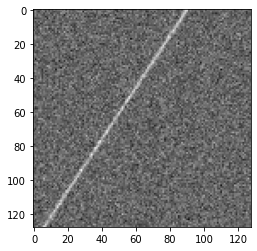

In [9]:
plt.imshow(train_images1[2799][ :, :,0], cmap='gray')

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [11]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images1).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [13]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32*32*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((32, 32, 256)))
    assert model.output_shape == (None, 32, 32, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 1)

    return model

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    except RuntimeError as e:
        print(e)

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [12]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

In [15]:
%%time
generator = make_generator_model()

noise = tf.random.normal([1, 100])

CPU times: user 62.6 ms, sys: 11.4 ms, total: 74 ms
Wall time: 74.1 ms


CPU times: user 4min 56s, sys: 483 ms, total: 4min 56s
Wall time: 4min 56s


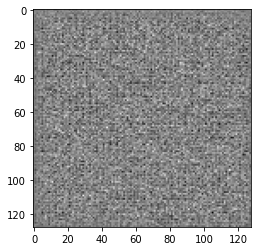

In [16]:
%%time
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [19]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [20]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00038274]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [21]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [24]:
global_step = tf.Variable(0, trainable=False)
decayed_lr = tf.compat.v1.train.exponential_decay(1e-5,
                                        global_step, 10000,
                                        0.95, staircase=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

In [25]:
global_step

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0>

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [26]:
#checkpoint_dir = './training_checkpoints'
#checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
#checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                 discriminator_optimizer=discriminator_optimizer,
#                                 generator=generator,
#                                 discriminator=discriminator)

## Define the training loop


In [27]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [28]:
# tf.compat.v1.enable_eager_execution()

In [29]:

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
g_loss = []
d_loss = []
# @tf.function
def train_step(images):
  
    #sess = tf.compat.v1.Session()
    #with sess.as_default():
    
    # noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # history = generator(noise, training=True)
      # print(history.history)
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)


        # d_loss.append(disc_loss.eval({input_z: batch_z, input_images: batch_images}))
        # print(disc_loss.numpy())
        # print(type(disc_loss))
        # with tf.compat.v1.Session() as sess:
        #     print(gen_loss.eval())
        #     print(disc_loss.eval())

        g_loss.append(gen_loss.numpy())
        d_loss.append(disc_loss.numpy())

        # g_l.append(gen_loss.numpy())
        # d_l.append(disc_loss.numpy())

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    # print(g_l)
    return gen_loss, disc_loss

In [30]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        g_l = []
        d_l = []
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

            g_l.append(gen_loss.numpy())
            d_l.append(disc_loss.numpy())
    # print(g_l)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed, round(sum(g_l)/20,2), round(sum(d_l)/20,2))

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed, round(sum(g_l)/20,2), round(sum(d_l)/20,2))

**Generate and save images**


In [31]:
def generate_and_save_images(model, epoch, test_input, g_l, d_l):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(5, 5))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')

        plt.axis('off')

    fig.suptitle("Epoch: "+str(epoch)+'\n Generator loss: '+str(g_l)+'\n Discriminator loss: '+str(d_l)+
               '\n Total loss: '+str(round((d_l+g_l),2)), fontsize = 18, y=1.15)
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch),bbox_inches='tight')
    plt.show()

In [32]:
%%time
train(train_dataset, EPOCHS)

KeyboardInterrupt: 

In [ ]:
# 28min 25min


Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
img = generator(seed, training=False)
plt.imshow(np.abs(img[1, :, :, 0]))


# Training Process

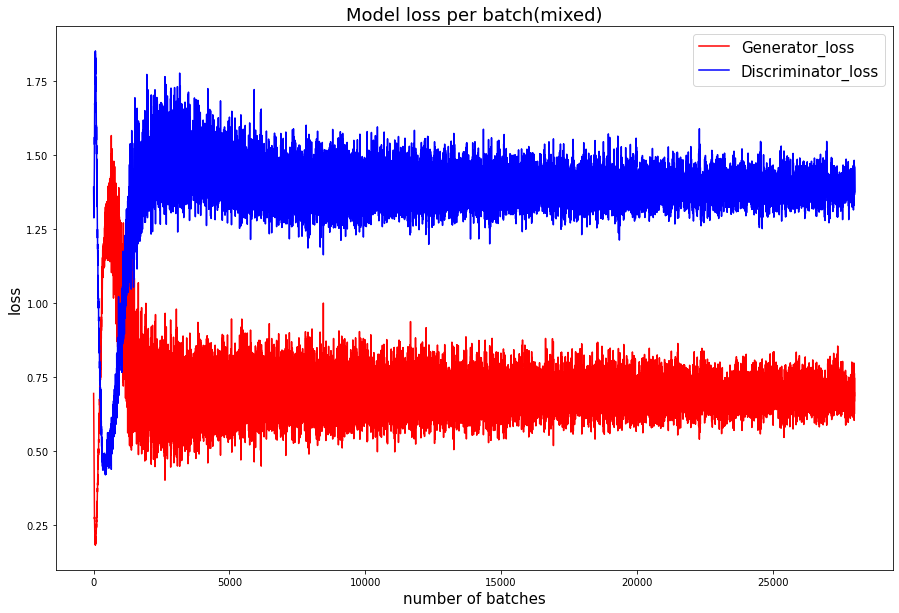

In [ ]:
pd.DataFrame(g_loss, columns=['g_loss']).to_csv("g_loss_mixed.csv", index = False, header = None)
pd.DataFrame(d_loss, columns=['d_loss']).to_csv("d_loss_mixed.csv", index = False, header = None)
plt.figure(figsize=(15,10))
plt.plot(g_loss,color='red',label='Generator_loss')
plt.plot(d_loss,color='blue',label='Discriminator_loss')
plt.legend(fontsize = 15)
plt.xlabel('number of batches', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.title('Model loss per batch(mixed)', fontsize = 18)
# plt.xlabel('Number of spectrograms generated', fontsize = 15)
# plt.ylabel('Time (seconds)', fontsize = 15)
plt.show()

In [ ]:
pd.DataFrame(g_loss, columns=['g_loss']).to_csv("g_loss_noisy.csv", index = False, header = None)
pd.DataFrame(d_loss, columns=['d_loss']).to_csv("d_loss_noisy.csv", index = False, header = None)
plt.figure(figsize=(15,10))
plt.plot(g_loss,color='red',label='Generator_loss')
plt.plot(d_loss,color='blue',label='Discriminator_loss')
plt.legend(fontsize = 15)
plt.xlabel('number of batches', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.title('Model loss per batch(noisy)', fontsize = 18)
# plt.xlabel('Number of spectrograms generated', fontsize = 15)
# plt.ylabel('Time (seconds)', fontsize = 15)
plt.show()


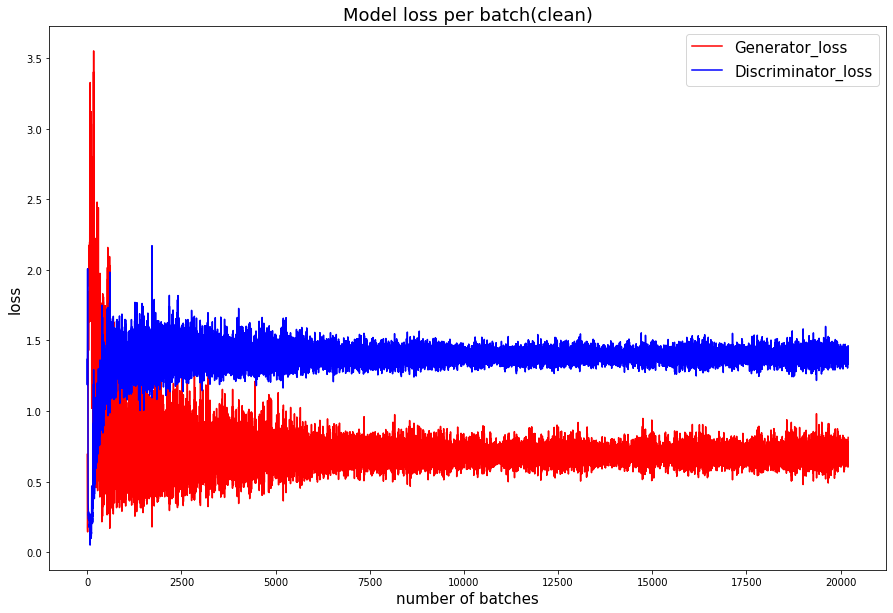

In [ ]:
pd.DataFrame(g_loss, columns=['g_loss']).to_csv("g_loss_clean.csv", index = False, header = None)
pd.DataFrame(d_loss, columns=['d_loss']).to_csv("d_loss_clean.csv", index = False, header = None)
plt.figure(figsize=(15,10))
plt.plot(g_loss,color='red',label='Generator_loss')
plt.plot(d_loss,color='blue',label='Discriminator_loss')
plt.legend(fontsize = 15)
plt.xlabel('number of batches', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.title('Model loss per batch(clean)', fontsize = 18)
# plt.xlabel('Number of spectrograms generated', fontsize = 15)
# plt.ylabel('Time (seconds)', fontsize = 15)
plt.show()

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

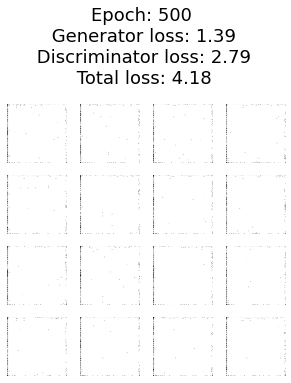

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  i = 0
  for filename in filenames:
    i+=1
    image = imageio.imread(filename)
    # image.setflags('i')
    writer.append_data(image)
    
  image = imageio.imread(filename)
  writer.append_data(image)

In [17]:
#import tensorflow_docs.vis.embed as embed
#embed.embed_file(anim_file)

## Next steps


This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs see the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).
